In [1]:
import autorootcwd

In [2]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from src.data import heart_disease, titanic, artificial
from src.irls import IRLS


In [3]:
# disable warnings
import warnings

warnings.filterwarnings("ignore")


## Prepare data

In [4]:
# prepare the data
X_heart, y_heart = heart_disease.prepare_data()
X_titanic, y_titanic = titanic.prepare_data()
X_artificial, y_artificial, true_weights = artificial.generate_data(
    num_samples=1000, num_features=5, interaction_pairs=None
)

# split the data into train and test sets
X_train_heart, X_test_heart, y_train_heart, y_test_heart = train_test_split(
    X_heart,
    y_heart,
    test_size=0.2,
    random_state=42,
)
X_train_titanic, X_test_titanic, y_train_titanic, y_test_titanic = train_test_split(
    X_titanic,
    y_titanic,
    test_size=0.2,
    random_state=42,
)
X_train_artificial, X_test_artificial, y_train_artificial, y_test_artificial = train_test_split(
    X_artificial,
    y_artificial,
    test_size=0.2,
    random_state=42,
)

Dropped colinear columns: ['sex_1.0', 'cp_4.0', 'fbs_1.0', 'restecg_2.0', 'exang_1.0', 'slope_1.0', 'slope_2.0']
Dropped: ['Sex_female', 'Sex_male', 'Embarked_S', 'Pclass_1', 'Pclass_3']


In [5]:
# print shapes and dtypes
print("X_train_heart:", X_train_heart.shape, X_train_heart.dtype)
print("y_train_heart:", y_train_heart.shape, y_train_heart.dtype)
print("X_test_heart:", X_test_heart.shape, X_test_heart.dtype)
print("y_test_heart:", y_test_heart.shape, y_test_heart.dtype)
print()
print("X_train_titanic:", X_train_titanic.shape, X_train_titanic.dtype)
print("y_train_titanic:", y_train_titanic.shape, y_train_titanic.dtype)
print("X_test_titanic:", X_test_titanic.shape, X_test_titanic.dtype)
print("y_test_titanic:", y_test_titanic.shape, y_test_titanic.dtype)
print()
print("X_train_artificial:", X_train_artificial.shape, X_train_artificial.dtype)
print("y_train_artificial:", y_train_artificial.shape, y_train_artificial.dtype)
print("X_test_artificial:", X_test_artificial.shape, X_test_artificial.dtype)
print("y_test_artificial:", y_test_artificial.shape, y_test_artificial.dtype)


X_train_heart: (242, 16) float32
y_train_heart: (242,) int64
X_test_heart: (61, 16) float32
y_test_heart: (61,) int64

X_train_titanic: (712, 7) float32
y_train_titanic: (712,) int64
X_test_titanic: (179, 7) float32
y_test_titanic: (179,) int64

X_train_artificial: (800, 5) float64
y_train_artificial: (800,) int64
X_test_artificial: (200, 5) float64
y_test_artificial: (200,) int64


## Fit and evaluate the classifiers

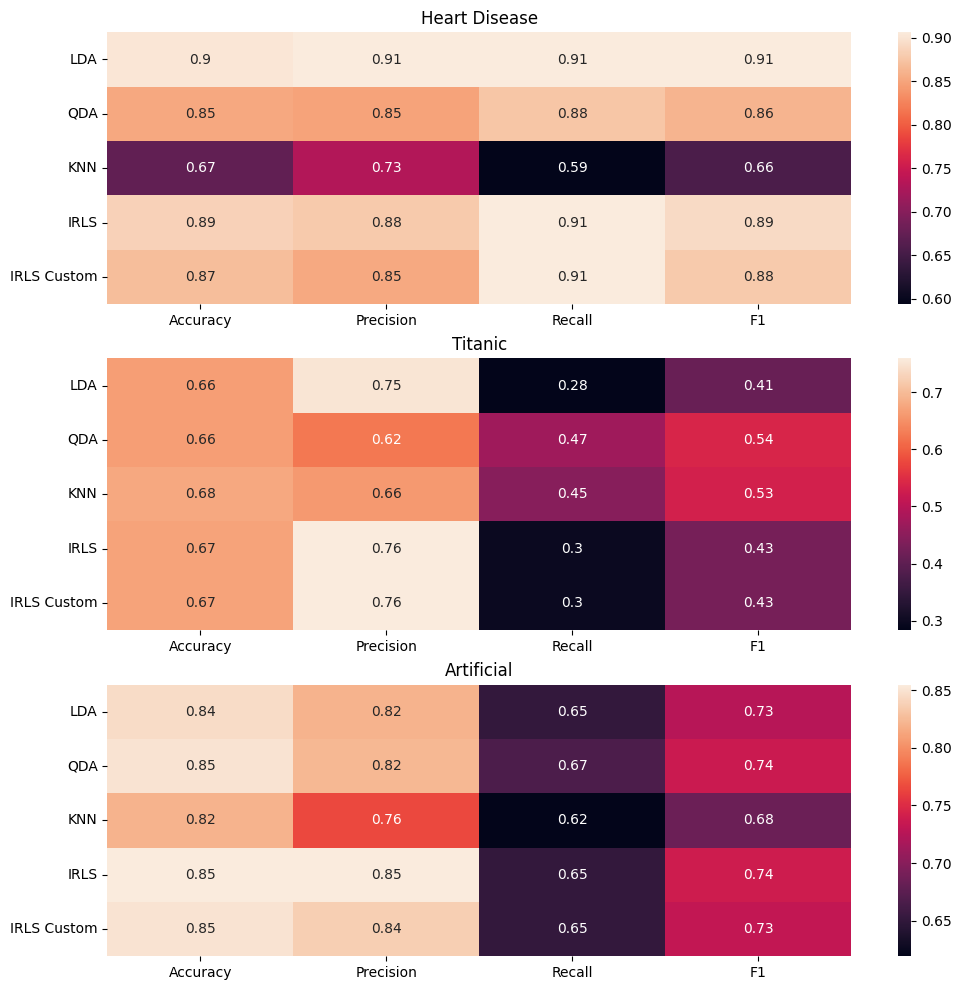

In [10]:
# Define a function to evaluate the classifiers
def evaluate_classifiers(X_train, X_test, y_train, y_test):
    # Create classifiers
    lda = LinearDiscriminantAnalysis()
    qda = QuadraticDiscriminantAnalysis()
    knn = KNeighborsClassifier()
    irls = LogisticRegression(solver="newton-cg")
    irls_custom = IRLS()

    # Fit classifiers on the training data
    lda.fit(X_train, y_train)
    qda.fit(X_train, y_train)
    knn.fit(X_train, y_train)
    irls.fit(X_train, y_train)
    irls_custom.fit(X_train, y_train)

    # Evaluate classifiers on the test data
    lda_scores = [
        accuracy_score(y_test, lda.predict(X_test)),
        precision_score(y_test, lda.predict(X_test)),
        recall_score(y_test, lda.predict(X_test)),
        f1_score(y_test, lda.predict(X_test)),
    ]

    qda_scores = [
        accuracy_score(y_test, qda.predict(X_test)),
        precision_score(y_test, qda.predict(X_test)),
        recall_score(y_test, qda.predict(X_test)),
        f1_score(y_test, qda.predict(X_test)),
    ]

    knn_scores = [
        accuracy_score(y_test, knn.predict(X_test)),
        precision_score(y_test, knn.predict(X_test)),
        recall_score(y_test, knn.predict(X_test)),
        f1_score(y_test, knn.predict(X_test)),
    ]

    irls_scores = [
        accuracy_score(y_test, irls.predict(X_test)),
        precision_score(y_test, irls.predict(X_test)),
        recall_score(y_test, irls.predict(X_test)),
        f1_score(y_test, irls.predict(X_test)),
    ]

    irls_custom_scores = [
        accuracy_score(y_test, irls_custom.predict(X_test) > 0.5),
        precision_score(y_test, irls_custom.predict(X_test) > 0.5),
        recall_score(y_test, irls_custom.predict(X_test) > 0.5),
        f1_score(y_test, irls_custom.predict(X_test) > 0.5),
    ]

    # Return the scores
    return pd.DataFrame(
        [lda_scores, qda_scores, knn_scores, irls_scores, irls_custom_scores],
        index=["LDA", "QDA", "KNN", "IRLS", "IRLS Custom"],
        columns=["Accuracy", "Precision", "Recall", "F1"],
    )


# Evaluate the classifiers on all datasets
heart_scores = evaluate_classifiers(X_train_heart, X_test_heart, y_train_heart, y_test_heart)
titanic_scores = evaluate_classifiers(X_train_titanic, X_test_titanic, y_train_titanic, y_test_titanic)
artificial_scores = evaluate_classifiers(X_train_artificial, X_test_artificial, y_train_artificial, y_test_artificial)

# Plot the scores
fig, axes = plt.subplots(3, 1, figsize=(12, 12))
sns.heatmap(heart_scores, annot=True, ax=axes[0])
sns.heatmap(titanic_scores, annot=True, ax=axes[1])
sns.heatmap(artificial_scores, annot=True, ax=axes[2])
axes[0].set_title("Heart Disease")
axes[1].set_title("Titanic")
axes[2].set_title("Artificial")
plt.show()

## Compare performance of custom IRLS on titanic and heart disease datasets with and without interactions

In [11]:
print("X_train_heart:", X_train_heart.shape, X_train_heart.dtype)
print("y_train_heart:", y_train_heart.shape, y_train_heart.dtype)
print("X_test_heart:", X_test_heart.shape, X_test_heart.dtype)
print("y_test_heart:", y_test_heart.shape, y_test_heart.dtype)
print()
print("X_train_titanic:", X_train_titanic.shape, X_train_titanic.dtype)
print("y_train_titanic:", y_train_titanic.shape, y_train_titanic.dtype)
print("X_test_titanic:", X_test_titanic.shape, X_test_titanic.dtype)
print("y_test_titanic:", y_test_titanic.shape, y_test_titanic.dtype)


X_train_heart: (242, 16) float32
y_train_heart: (242,) int64
X_test_heart: (61, 16) float32
y_test_heart: (61,) int64

X_train_titanic: (712, 7) float32
y_train_titanic: (712,) int64
X_test_titanic: (179, 7) float32
y_test_titanic: (179,) int64


In [35]:
import itertools

interaction_pairs_list = []

for i in range(2, 8):
    interaction_pairs = list(itertools.combinations(range(0, i), 2))
    interaction_pairs_list.append(interaction_pairs)
    print(interaction_pairs)

interaction_pairs_list = [None] + interaction_pairs_list

[(0, 1)]
[(0, 1), (0, 2), (1, 2)]
[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
[(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]
[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5)]
[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 3), (2, 4), (2, 5), (2, 6), (3, 4), (3, 5), (3, 6), (4, 5), (4, 6), (5, 6)]


In [24]:
# print("num pairs:", len(irls_custom.interaction_pairs))

ds1 = (X_train_heart, X_test_heart, y_train_heart, y_test_heart)
ds2 = (X_train_titanic, X_test_titanic, y_train_titanic, y_test_titanic)

results = []

# compare for both datasets
for interaction_pairs in interaction_pairs_list:
    for X_train, X_test, y_train, y_test in [ds1, ds2]:
        irls_custom = IRLS(interaction_pairs=interaction_pairs, max_iter=1000, tol=1e-6)

        # Fit the model
        irls_custom.fit(X_train, y_train)

        # Evaluate the model
        irls_custom_scores = [
            accuracy_score(y_test, irls_custom.predict(X_test) > 0.5),
            precision_score(y_test, irls_custom.predict(X_test) > 0.5),
            recall_score(y_test, irls_custom.predict(X_test) > 0.5),
            f1_score(y_test, irls_custom.predict(X_test) > 0.5),
        ]


      Accuracy  Precision   Recall        F1
IRLS  0.868852   0.852941  0.90625  0.878788
      Accuracy  Precision    Recall        F1
IRLS  0.670391   0.758621  0.297297  0.427184


In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a list of interaction pair names
interaction_pair_names = [f"Interaction Pair {i}" for i in range(len(interaction_pairs_list))]

# Create an empty DataFrame to store the evaluation scores
scores_df = pd.DataFrame(columns=["Dataset", "Interaction Pair", "Metric", "Score"])

# Loop over each dataset and interaction pair, and evaluate the model
for ds_name, dataset in [("Dataset 1", ds1), ("Dataset 2", ds2)]:
    for i, interaction_pairs in enumerate(interaction_pairs_list):
        irls_custom = IRLS(interaction_pairs=interaction_pairs, max_iter=1000, tol=1e-6)
        irls_custom.fit(dataset[0], dataset[2])
        y_pred = irls_custom.predict(dataset[1]) > 0.5
        scores = [
            ("Accuracy", accuracy_score(dataset[3], y_pred)),
            ("Precision", precision_score(dataset[3], y_pred)),
            ("Recall", recall_score(dataset[3], y_pred)),
            ("F1-Score", f1_score(dataset[3], y_pred)),
        ]
        for metric, score in scores:
            scores_df = scores_df.append(
                {"Dataset": ds_name, "Interaction Pair": f"Interaction Pair {i}", "Metric": metric, "Score": score},
                ignore_index=True,
            )

# Plot the results using seaborn
sns.set(style="ticks")
sns.catplot(
    x="Interaction Pair", y="Score", hue="Metric", col="Dataset", data=scores_df, kind="bar", height=4, aspect=1
)
plt.show()


LinAlgError: Singular matrix